# Rainfall Prediction Project

## Data Loading, combining and EDA

*Group 12*

------------

In [2]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import rpy2.rinterface
import altair as alt

## Download the data

In [2]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../data/raw/figsharerainfall/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

In [4]:
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [5]:
with zipfile.ZipFile(os.path.join(output_directory, files_to_dl[0]), 'r') as f:
    f.extractall(output_directory)

## Combine the data

In [6]:
%%time
exclude = "observed_daily_rainfall_SYD.csv"
files = glob.glob('../data/raw/figsharerainfall/*.csv')
df = pd.concat(
    (pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[A-Z][^_]+', file)[0])
                for file in files if file is not exclude)
)
df.to_csv("../data/processed/combined_data.csv")

CPU times: user 6min 11s, sys: 10.3 s, total: 6min 21s
Wall time: 6min 30s


In [7]:
df = pd.read_csv("../data/processed/combined_data.csv")
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [8]:
df.tail()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
62513858,2014-12-27 12:00:00,-30.157068,-29.21466,153.125,154.375,6.689683,SAM0-UNICON
62513859,2014-12-28 12:00:00,-30.157068,-29.21466,153.125,154.375,7.862555,SAM0-UNICON
62513860,2014-12-29 12:00:00,-30.157068,-29.21466,153.125,154.375,10.005026,SAM0-UNICON
62513861,2014-12-30 12:00:00,-30.157068,-29.21466,153.125,154.375,8.541592,SAM0-UNICON
62513862,2014-12-31 12:00:00,-30.157068,-29.21466,153.125,154.375,68.117489,SAM0-UNICON


## Combine data csv on different machines

- Compare observations:

| Team Member   | Operating System | RAM | Processor | Is SSD | Time taken |
|:-------------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Vera Cui      | macOS            | 16GB| M1        | No     | 6min 39s   |
| Lynn Wu       | macOS            | 8GB | M1        | Yes    |  6min 7s   |
| Jasmine Ortega|  macOS         |  8GB |   M1   |  Yes   | 9min 56s     |
| Yike Shi   | MacOS Big Sur    | 8GB | 2.3 GHz Dual-Core Intel Core i5 | Yes |  7min 30s   |

--------------

##  Load csv and perform EDA on different machines

#### Baseline `read_csv` time

In [9]:
%%time
df = pd.read_csv("../data/processed/combined_data.csv")

CPU times: user 45.7 s, sys: 11.3 s, total: 56.9 s
Wall time: 1min 8s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62513863 entries, 0 to 62513862
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.3+ GB


| Team Member   | Operating System | RAM | Processor | Is SSD | Time taken |
|:-------------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Vera Cui      | macOS            | 16GB| M1        | No     | 56.3 s     |
| Lynn Wu       | macOS            | 8GB |   M1      |  yes   | 1min 8s    |
| Jasmine Ortega|  MacOS           |8GB  |    M1     |  yes   |1 min 9s    |
| Yike Shi      |    macOS              |  8GB   | 2.3 GHz Dual-Core Intel Core i5 | Yes |  1min 16s   |

As is, the csv file took 1 minute and 46 seconds to load. From `.info()` we can see that the df consists of 6 columns all of the dtype `float64`. To reduce memory usage, we will first convert the data type to `float32` and `float16`, both which will reduce memory used, as shown below.

In [11]:
print(f"Memory usage with float64: {df.memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df.astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float16: {df.astype('float16', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3500.78 MB
Memory usage with float32: 2250.50 MB
Memory usage with float16: 1625.36 MB


#### Approaches to reduce memory usage while performing the EDA: *changing datatype*
##### Convert to float32

In [12]:
%%time
dtypes = {"lat_min" : "float32",
         "lat_max" : "float32",
         "lon_min" : "float32",
         "lon_max" : "float32",
         "rain (mm/day)" : "float32",
          "model" : "string"
        }

df_float32 = pd.read_csv('../data/processed/combined_data.csv', dtype=dtypes)

CPU times: user 46.1 s, sys: 6.82 s, total: 52.9 s
Wall time: 1min


In [13]:
df_float32.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62513863 entries, 0 to 62513862
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float32
 2   lat_max        float32
 3   lon_min        float32
 4   lon_max        float32
 5   rain (mm/day)  float32
 6   model          string 
dtypes: float32(5), object(1), string(1)
memory usage: 2.1+ GB


##### Convert to float16

In [3]:
%%time
dtypes = {"lat_min" : "float16",
         "lat_max" : "float16",
         "lon_min" : "float16",
         "lon_max" : "float16",
         "rain (mm/day)" : "float16",
        "model" : "string"
        }

df_float16 = pd.read_csv('../data/processed/combined_data.csv', dtype=dtypes)

CPU times: user 43.4 s, sys: 5.62 s, total: 49 s
Wall time: 52.4 s


In [4]:
df_float16 

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.43750,-33.56250,141.500,143.500,0.000000,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.43750,-33.56250,141.500,143.500,0.000000,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.43750,-33.56250,141.500,143.500,0.000000,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.43750,-33.56250,141.500,143.500,0.000000,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.43750,-33.56250,141.500,143.500,0.000000,MPI-ESM-1-2-HAM
...,...,...,...,...,...,...,...
62513858,2014-12-27 12:00:00,-30.15625,-29.21875,153.125,154.375,6.691406,SAM0-UNICON
62513859,2014-12-28 12:00:00,-30.15625,-29.21875,153.125,154.375,7.863281,SAM0-UNICON
62513860,2014-12-29 12:00:00,-30.15625,-29.21875,153.125,154.375,10.007812,SAM0-UNICON
62513861,2014-12-30 12:00:00,-30.15625,-29.21875,153.125,154.375,8.539062,SAM0-UNICON


As demonstrated, changing `float64` to less precise datatypes reduced runtimes. Interestingly, it looks like `float16` (50s) took almost as long to load as the more precise `float32` (58s). 

#### Approaches to reduce memory usage while performing the EDA: *Loading in chunks*

In [5]:
%%time

chunk = pd.read_csv("../data/processed/combined_data.csv", chunksize=10_000_000, iterator=True)
df = pd.concat(chunk)
df

CPU times: user 44.9 s, sys: 10.8 s, total: 55.7 s
Wall time: 1min 3s


,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM
...,...,...,...,...,...,...,...
62513858,2014-12-27 12:00:00,-30.157068,-29.214660,153.1250,154.3750,6.689683e+00,SAM0-UNICON
62513859,2014-12-28 12:00:00,-30.157068,-29.214660,153.1250,154.3750,7.862555e+00,SAM0-UNICON
62513860,2014-12-29 12:00:00,-30.157068,-29.214660,153.1250,154.3750,1.000503e+01,SAM0-UNICON
62513861,2014-12-30 12:00:00,-30.157068,-29.214660,153.1250,154.3750,8.541592e+00,SAM0-UNICON


Loading the data in chunks of 10,000,000 reduced the loading time to 1min 7s. Let's combine the `float32` strategy with loading in chunks! (Note: we use `float32` instead of `float16` because half precision types are not supported when loading the data in chunks.  

In [6]:
%%time

dtypes = {"lat_min" : "float32",
         "lat_max" : "float32",
         "lon_min" : "float32",
         "lon_max" : "float32",
         "rain (mm/day)" : "float32",
         "model" : "string"
        }

final_df = pd.DataFrame()

chunk = pd.read_csv("../data/processed/combined_data.csv", chunksize=10_000_000, iterator=True, dtype=dtypes)
final_df = pd.concat(chunk)

CPU times: user 45.6 s, sys: 7.01 s, total: 52.6 s
Wall time: 58.8 s


In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62513863 entries, 0 to 62513862
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float32
 2   lat_max        float32
 3   lon_min        float32
 4   lon_max        float32
 5   rain (mm/day)  float32
 6   model          string 
dtypes: float32(5), object(1), string(1)
memory usage: 2.1+ GB


We successfully reduced the load time from 1min 9s to 54.9s. 


**Optimized data loading:**

| Team Member   | Operating System | RAM | Processor | Is SSD | Time taken |
|:-------------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Vera Cui      | macOS            | 16GB| M1        | No     | 51.4 s     |
| Lynn Wu       |   macOS          | 8GB |  M1       |   yes  | 58.8s      |
| Jasmine Ortega|  MacOS           |8GB  |    M1     |  yes   |54.9s       |
| Yike Shi      |     macOS             |   8GB  | 2.3 GHz Dual-Core Intel Core i5 | Yes |  1min 2s  |

Now, we will load the data (optimized) and conduct a simple EDA in which we will count the number of each model in the dataframe. 

In [8]:
%%time

dtypes = {"lat_min" : "float32",
         "lat_max" : "float32",
         "lon_min" : "float32",
         "lon_max" : "float32",
         "rain (mm/day)" : "float32",
         "model" : "string"
        }

final_df = pd.DataFrame()

chunk = pd.read_csv("../data/processed/combined_data.csv", chunksize=10_000_000, iterator=True, dtype=dtypes)
final_df = pd.concat(chunk)

# EDA
model_count = final_df["model"].value_counts()
model_count

CPU times: user 48.2 s, sys: 6.71 s, total: 54.9 s
Wall time: 59.5 s


MPI-ESM1-2-HR       5154240
NorESM2-MM          3541230
CMCC-CM2-SR5        3541230
TaiESM1             3541230
CMCC-ESM2           3541230
CMCC-CM2-HR4        3541230
SAM0-UNICON         3541153
GFDL-CM4            3219300
FGOALS-f3-L         3219300
GFDL-ESM4           3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
SYD.csv               46020
Name: model, dtype: Int64

**Python data load + EDA time:**

| Team Member   | Operating System | RAM | Processor | Is SSD | Time taken |
|:-------------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Vera Cui      | macOS            | 16GB| M1        | No     | 55.6 s     |
| Lynn Wu       | macOS            |8GB  |    M1     | yes    |  59.5s     |
| Jasmine Ortega|  MacOS           |8GB  |    M1     |  yes   |58.5 s      |
| Yike Shi      |         macOS         |  8GB   |   2.3 GHz Dual-Core Intel Core i5 | Yes |  56.8s  |

It looks like it takes ~1 minute to load and execute the EDA using the datatype `float32` and loading in chunks of 10,000,0000. 

(We attempted to plot the value counts, however, it consistently crashed the kernel on Mac M1) 

In [ ]:
# alt.data_transformers.disable_max_rows()
# alt.renderers.enable('mimetype')

In [ ]:
# this kills my kernel but you can try it lol 
# count_plot = alt.Chart(final_df).mark_bar().encode(x='model', y='count()')# this kills my kernel but you can try it lol 
# count_plot

#### Transform Python df to R Parquet 

We chose to use a parquet file to transfer the dataframe from Python to R because parquet files work well with rarrow. rarrow is ideal because by default, it reads and processes data in chunks, which we saw greatly improved our CSV loading time.

In [9]:
final_df.to_parquet("../data/processed/combined_data.parquet")

#### Perform a simple EDA in R

In [10]:
%load_ext rpy2.ipython

In [11]:
%%time 
%%R
library(dplyr)
library(arrow)


df <- open_dataset("../data/processed/combined_data.parquet") 

eda <- df |> count(model)
eda

result <- eda %>% collect
print(result, n=28)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘arrow’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp




# A tibble: 28 × 2
   model                  n
   <chr>              <int>
 1 FGOALS-f3-L      3219300
 2 CMCC-CM2-HR4     3541230
 3 MRI-ESM2-0       3037320
 4 BCC-CSM2-MR      3035340
 5 ACCESS-ESM1-5    1610700
 6 MPI-ESM1-2-HR    5154240
 7 NorESM2-MM       3541230
 8 CMCC-CM2-SR5     3541230
 9 INM-CM5-0        1609650
10 MIROC6           2070900
11 SAM0-UNICON      3541153
12 NorESM2-LM        919800
13 ACCESS-CM2       1932840
14 GFDL-CM4         3219300
15 INM-CM4-8        1609650
16 TaiESM1          3541230
17 GFDL-ESM4        3219300
18 CanESM5           551880
19 EC-Earth3-Veg-LR 3037320
20 CMCC-ESM2        3541230
21 FGOALS-g3        1287720
22 AWI-ESM-1-1-LR    966420
23 NESM3             966420
24 MPI-ESM1-2-LR     966420
25 MPI-ESM-1-2-HAM   966420
26 KIOST-ESM        1287720
27 BCC-ESM1          551880
28 SYD.csv            46020
CPU times: user 3.79 s, sys: 511 ms, total: 4.3 s
Wall time: 2.46 s


**R data load + EDA time:**

| Team Member   | Operating System | RAM | Processor | Is SSD | Time taken |
|:-------------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Vera Cui      | macOS            | 16GB| M1        | No     | 6.01 s     |
| Lynn Wu       | macOS            |8GB  | M1        |  yes   |   2.46s    |
| Jasmine Ortega|  MacOS           |8GB  |    M1     |  yes   |2.49 s      |
| Yike Shi      |      macOS            |  8GB   |    2.3 GHz Dual-Core Intel Core i5 | Yes |  4.25s |

Overall, using a parquet file to transfer a Python dataframe to R was extremely effective. Considering the sheer volume of data we have (62 million rows), it's amazing that R was able to compute value counts in 2.5 seconds! Compare to Python, which took 58.5 seconds to complete the same task. From this simple experiment alone, it is clear to see the value of using an optimized storage file like a parquet over a CSV. 

In [21]:
%%R
.libPaths()

[1] "/Users/beilinwu/opt/miniconda3/envs/525_2022/lib/R/library"


R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



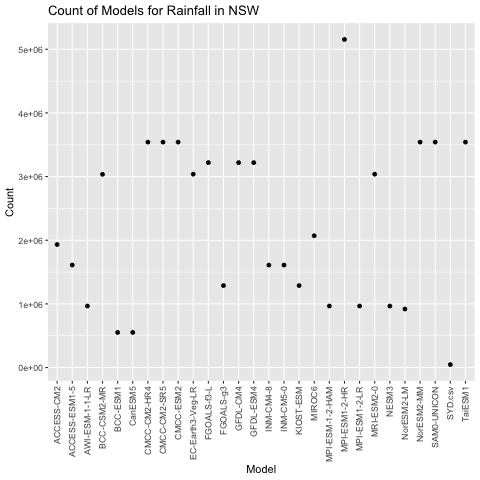

In [24]:
%%R
#install.packages("ggplot2")
library(ggplot2)
library(tidyverse)

count_eda <- result|>
            ggplot(aes(x=model, y=n)) + geom_point() +
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
            xlab("Model") + ylab("Count") +
            ggtitle("Count of Models for Rainfall in NSW")
            
count_eda